In [341]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
import random

In [342]:
# load breast cancer
data = load_breast_cancer()
indices = np.random.permutation(len(data.target))
data.data, data.target = data.data[indices], data.target[indices]

[data sepecification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

In [343]:
# define Dataset
class Dataset:
    def __init__(self, dataset):
      self.x, self.y = dataset
    def __getitem__(self, item): return self.x[item], self.y[item]
    def __len__(self): return len(self.y)
# Dataset

def dataset_visualize(dataset: Dataset):
  for x, y in dataset: print(f"{'-' * 16}\nx: {x}\ny: {y}")
# dataset_visualize

# init Datasets
trainset = Dataset((data.data[:], data.target[:]))
testset = Dataset((data.data[0:100], data.target[0:100]))
###dataset_visualize(trainset)

In [344]:
def sigmoid(x): return 1 / (1 + np.exp(-1 * np.clip(x, -1e2, 1e2)))

In [345]:
class LogisticRegression:
    def __init__(self, n_inpt, act_func):
      self.weight = np.zeros(shape=(n_inpt))
      self.act_func = act_func
    # __init__

    def gdr(self, x, y, lr):
      indications = self.__call__(x)
      self.weight -= (lr / x.shape[0]) * np.dot(x.T, (indications - y))
    # gdr

    def train(self, dataset, iters: int, lr=0.01):
        for _ in range(iters):
          self.gdr(dataset.x, dataset.y, lr=lr)
    # train

    def __call__(self, x): return sigmoid(np.dot(x, self.weight))

    def loss(self, dataset):
        x, y = dataset.x, dataset.y
        probability = self.__call__(x)
        loss = np.mean((y - probability) ** 2)
        print(f"loss: {loss:.3f}")
    # loss
# LogisticRegression

In [346]:
model = LogisticRegression(len(trainset.x[0]), sigmoid)
model.loss(trainset)
model.train(trainset, iters=1000, lr=0.001)
model.loss(testset)

loss: 0.250
loss: 0.070


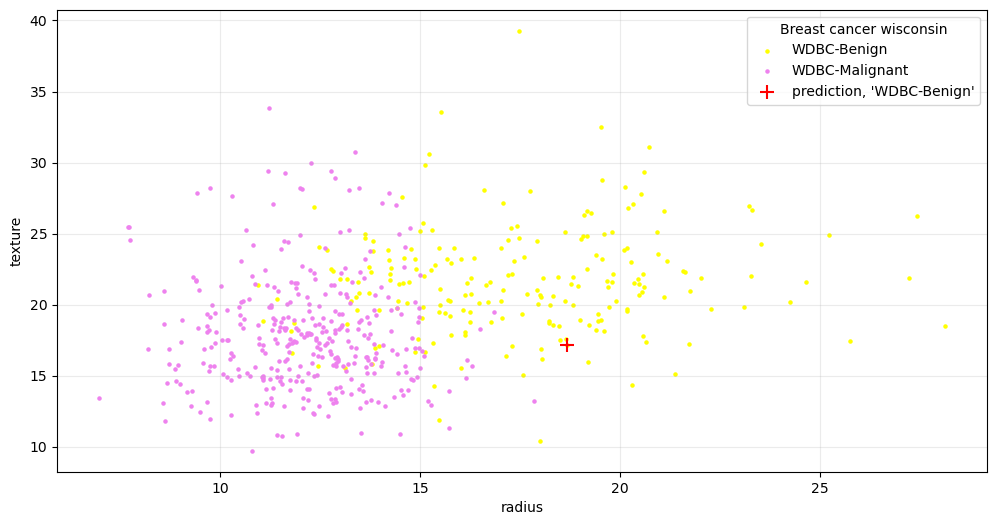

In [347]:
# init a testset
index = random.randrange(0, 50)
test_x, test_y = testset[index]

benign = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if trainset.y[_] == 0])
malignant = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if trainset.y[_] == 1])
pred = model(test_x)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.set_xlabel('radius')
ax1.set_ylabel('texture')
ax1.grid(True, alpha=0.25)

ax1.scatter(x=benign[:, 0], y=benign[:, 1], s=5, alpha=1, c="yellow", label="WDBC-Benign")
ax1.scatter(x=malignant[:, 0], y=malignant[:, 1], s=5, alpha=1, c="violet", label="WDBC-Malignant")
ax1.scatter(x=test_x[0], y=test_x[1], s=100, marker="+", alpha=1, c="r", label=f"prediction, '{'WDBC-Malignant' if pred == 1 else 'WDBC-Benign'}'")
ax1.legend(fontsize="10", loc="best", title="Breast cancer wisconsin")

In [348]:
print(f"predicted class: {int(pred)} actual class: {test_y}")

predicted class: 0 actual class: 0
